# Cassandra'21 Competition NOTEBOOK

This notebook contains our approach on dealing with the dataset of Cassandra which have very less correlation in training and testing,We will later explain that the scores in private and public leadreboard is not a result of overfit but a result of randomness and less correlation in train and testing distribution which makes the cross validation of train data less trustworthy.

In [94]:

# lOading libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import optuna
from tqdm.notebook import tqdm as tn
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, auc, roc_curve

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

## Loading Data

In [ ]:
train_meta = pd.read_csv("../input/cassandra-udyam21/payment_history_data.csv")
train = pd.read_csv("../input/cassandra-udyam21/user_data_training.csv")
test = pd.read_csv("../input/cassandra-udyam21/user_data_testing.csv")
sample_Submission = pd.read_csv("../input/cassandra-udyam21/Sample Submission.csv")
train

In [ ]:
train,head()

### Initial Preprocessing on train and test data

Before moving on to the actual preprocessing **we done a most basic step is to remove extra noise and outliers based on the inter quartile range**


In [96]:
from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 3.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,train.columns[2:])  # we picked those rows which 
                                                            # contained outliers in more than 2 columns of it

We found that there are around 100 such rows in train data out of which 90 have label 0 and 10 have 1 label so based on the data imbalance we decided to remove those 90 rows of 0, it made the imbalance as well as noise in data less.

In [8]:
## Now removing those outlier rows of 0 from train data as well as data of those ids from payment_history.csv

# removed from payment history.
for i in train.loc[Outliers_to_drop][train.loc[Outliers_to_drop]['label']==0].id.values:
    print(i)
    train_meta = train_meta[train_meta["id"]!=i].reset_index(drop=True)

1484006679
1486529479
1490253206
1489267459
1487335291
1491150284
772423
1486924223
2153656
1490862759
1487547132
1484012615
1114
1487069284
1490044704
1487894017
1371217
1489935259
3241428
1489211809
1490571524
1490902456
1484008534
1484907096
1258433
1486924594
1488777739
2512413
1489154675
1492283318
1488123295
1489086782
1414995
1490673178
1491887461
1491028225
1487308579
2172577
825105
1485296275
765374
1484025971
1487368310
1488158911
1488028690
1486255310
1489550532
1454692
1490391960
1193137
1486569176
2124718
1488426402
1487601298
1485005411
1459886
1286258
1484257846
2328768
1484541661
1486066842
1487550100
1485517391
1486566208
949761
1485407204
1486057938
1486571402
1485826434
1055125
1485584171
1486111362
1485810110
1488449404
1488431967
1484938260
1206864
586552
3514855
1488940237
1485803061
1486418179
1485737023
1489659235
533870
1488755850
1487602411
1326697
1484017809
1486201515
1486911238
2174432
1872809
1220591
1487070026
1488595578
1485239141
1488342185
1485432803
1

In [9]:
# removed from train
train.loc[Outliers_to_drop]['label'].values # Show the outliers rows
# Drop outliers
train = train.drop(train.loc[Outliers_to_drop][train.loc[Outliers_to_drop]['label']==0].index.values, axis = 0).reset_index(drop=True)

In [157]:
train_meta.groupby(["id"]).size()

id
1             18
12615         11
40811          2
65668          4
72717         10
              ..
1492771183     3
1492824607     4
1492844641     8
1492854287     3
1492861707     3
Length: 1012, dtype: int64

In [158]:
test

,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,omikron
0,1484353935,2615,1214.0,3,56000,2,15,5,101,5,60064,192.163993,0.029703
1,1490969236,2092,NaN,2,100000,2,8,9,99,5,71003,199.974998,0.020202
2,1487077817,3661,1223.0,3,78000,2,11,-1,75,5,450007,173.205081,0.040000
3,1485622755,2615,1214.0,3,68000,2,15,5,92,3,550044,173.205081,0.032609
4,1486796599,3661,NaN,2,63000,2,11,5,84,5,60019,158.113883,0.023810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,1489702642,2092,1313.0,3,134000,2,8,5,104,3,60054,244.948974,0.028846
406,1835338,3661,1125.5,3,79000,2,11,-1,107,5,450007,187.082869,0.028037
407,1236915,3661,1188.5,3,90000,2,11,5,98,5,60017,1.000000,0.030612
408,1489208099,3661,1386.5,1,165000,2,11,-1,100,3,350098,173.205081,0.010000


In [159]:
# taking description of data now to find the distribution.
train.describe()

,label,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,omikron
count,602.000000,6.020000e+02,602.000000,524.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,0.191030,1.051541e+09,2819.161130,1283.105916,2.395349,112624.584718,1.936877,10.686047,5.194352,100.682724,4.219269,127825.440199,125.127942,0.024092
std,0.393439,6.779381e+08,702.800684,49.929709,0.849691,64477.564571,0.243386,2.631457,2.431169,11.621341,0.842957,120823.933689,110.557187,0.009095
min,0.000000,8.384700e+04,2092.000000,1116.500000,1.000000,15000.000000,1.000000,6.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000,0.008696
25%,0.000000,3.126974e+06,2092.000000,1245.500000,2.000000,72250.000000,2.000000,8.000000,5.000000,90.000000,4.000000,60036.000000,1.000000,0.017544
50%,0.000000,1.486809e+09,2615.000000,1281.500000,3.000000,100000.000000,2.000000,11.000000,5.000000,104.000000,4.000000,72000.000000,173.205081,0.027027
75%,0.000000,1.490172e+09,3661.000000,1314.500000,3.000000,135000.000000,2.000000,11.000000,5.000000,110.000000,5.000000,151300.000000,200.000000,0.030000
max,1.000000,1.492862e+09,3661.000000,1469.000000,3.000000,500000.000000,2.000000,15.000000,10.000000,115.000000,5.000000,591001.000000,707.106781,0.046875


### Our observations after outlier removal (Observation No. -1)

1. we saw that some variables like Kappa and Lambda which shows less correlation with the data of around 0.01 nows 
showing decent correlation of around 0.12 and 0.09 which made us believe that actual outlier is a noise.

<AxesSubplot:xlabel='Beta', ylabel='Density'>

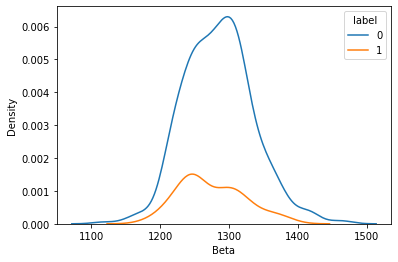

In [161]:
# Beta distribution in train data
sns.kdeplot(train['Beta'],data =train, hue ="label")

In [108]:
# labels cooresponding to beat nan values
train["label"][train['Beta'].isnull()].value_counts()

0    71
1    20
Name: label, dtype: int64

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   label    602 non-null    int64  
 1   id       602 non-null    int64  
 2   Alpha    602 non-null    int64  
 3   Beta     524 non-null    float64
 4   Gamma    602 non-null    int64  
 5   Delta    602 non-null    int64  
 6   Epsilon  602 non-null    int64  
 7   Zeta     602 non-null    int64  
 8   Eta      602 non-null    int64  
 9   Theta    602 non-null    int64  
 10  Iota     602 non-null    int64  
 11  Kappa    602 non-null    int64  
 12  Lambda   602 non-null    float64
 13  omikron  602 non-null    float64
dtypes: float64(3), int64(11)
memory usage: 66.0 KB


based on the above info we found that only beta in train and test data have nan values

In [73]:
print(train.nunique())

label        2
id         602
Alpha        4
Beta       126
Gamma        3
Delta      177
Epsilon      2
Zeta         6
Eta          9
Theta       45
Iota         4
Kappa      153
Lambda     155
omikron    102
dtype: int64


id          1012
Alpha          6
Beta         150
Gamma          3
Delta        207
Epsilon        2
Zeta           9
Eta           10
Theta          6
Iota           5
Kappa        236
Lambda       237
omikron      123
Del_bins       3
dtype: int64

In [87]:
## Unique values of all
print(train['Epsilon'].value_counts())
print(test['Epsilon'].value_counts())
print(train['Eta'].value_counts())
print(test['Eta'].value_counts())
print(train['Zeta'].value_counts())
print(test['Zeta'].value_counts())
print(train['Iota'].value_counts())
print(test['Iota'].value_counts())


2    564
1     38
Name: Epsilon, dtype: int64
2    380
1     30
Name: Epsilon, dtype: int64
 5     432
 9     104
-1      48
 2       8
 8       4
 3       2
 10      2
 1       1
 4       1
Name: Eta, dtype: int64
 5     254
 9      70
-1      67
 2       6
 8       4
 3       3
 7       3
 4       2
 10      1
Name: Eta, dtype: int64
8     234
11    233
15    130
9       2
12      2
6       1
Name: Zeta, dtype: int64
11    180
8     118
15    103
12      4
4       2
3       1
5       1
6       1
Name: Zeta, dtype: int64
5    285
4    170
3    144
1      3
Name: Iota, dtype: int64
5    179
4    115
3    113
1      2
2      1
Name: Iota, dtype: int64


In [74]:
print(train_meta.nunique())
train.isnull().sum()

id                         1012
Late_2                       21
Late_1                       15
Late_3                       33
days_late_Sum               338
normal_payment               37
p_code                       21
p_limit                     290
last_update                2778
curr_remaining             3470
max_bal                    4478
recent_payment_activity    1671
dtype: int64


label       0
id          0
Alpha       0
Beta       78
Gamma       0
Delta       0
Epsilon     0
Zeta        0
Eta         0
Theta       0
Iota        0
Kappa       0
Lambda      0
omikron     0
dtype: int64

In [90]:
train_meta.isnull().sum()

id                            0
Late_2                        0
Late_1                        0
Late_3                        0
days_late_Sum                 0
normal_payment                0
p_code                        0
p_limit                    5199
last_update                  23
curr_remaining                0
max_bal                     338
recent_payment_activity     934
dtype: int64

## Our Obsevations on Demographics data (Observation no-2)

Based on the three things that is 
a) Intutuon 
b) plotting featues
c) Reading about different features on internet.

We made some hypothesis about data and demographics features which are made anonymized:
1) **Dataset is not of bank loan but about credit card default dataset** as it contains a feature p_limit which decribes the credit limit expenditure and it contains features regarding late repayments and max balance in history which explains that it is about spending from a card and then repaying it.

2) Epsilon has 2 unique values so after studying from internet abount these type of data we hypothise that this feature must be one of *Sex -> male -0  and feamle-1 here female have low majority in data* or *must be about marital status married or not*

3) Gamma - Which contains 3 unique value must be the location from where customer is belonging i.e., to Urban, rural or Suburban areas.

4) Theta is a type of positive integer value which representing the age of person encoded in some style to make the maximum at 115 and min at 60

5) And out of Delta or kappa one must be the salary of the person.

6) Last but not least, Alpha which have 4 unique value seems to be random but actually in data it is modified ,if we divide Alpha by 523 we get **resultant in 1, 2, ,3 ,4 ,5 , 6, 7**, very expressive to see, it may represent the educational qualification of that customer whether they pass out high school, secondary and so on.

In [76]:
#Explaination of 523 division converted into nice categories
(train['Alpha']/523).value_counts()

4    236
7    235
5    130
6      1
Name: Alpha, dtype: int64

<AxesSubplot:xlabel='Alpha', ylabel='count'>

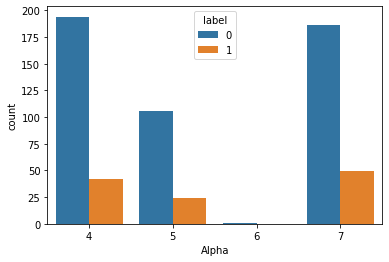

In [78]:
# distributoon represent label 6 is less prone to taking or frauding
#credit card as they are less in number, may be they are of early education years
sns.countplot(x=(train['Alpha']//523), data= train,hue='label')

<AxesSubplot:xlabel='Kappa', ylabel='Density'>

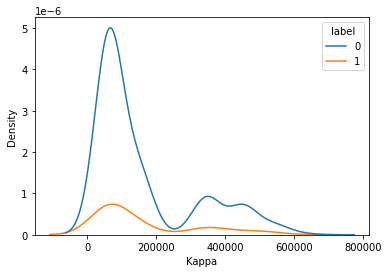

In [91]:
# Distribution of kappa showing two peaks at different region which seems that there is something in it.
sns.kdeplot(train["Kappa"], data = train, hue = "label")

<AxesSubplot:xlabel='Delta', ylabel='Density'>

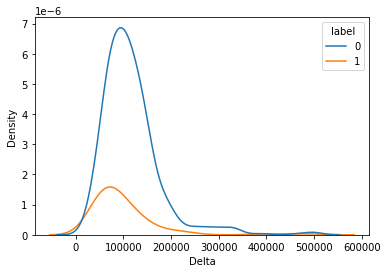

In [82]:
sns.kdeplot(train['Delta'], data = train, hue = "label")

Above plot depicts that as the amount is getting incresed we found that the testing label fequency almost reaches 0 but there is quite a good amount of person which is not defaulters, means if this feature represent salary then we can hypothize that huge salary made the bank trust more on customer compared to low ones

<AxesSubplot:xlabel='Beta', ylabel='Density'>

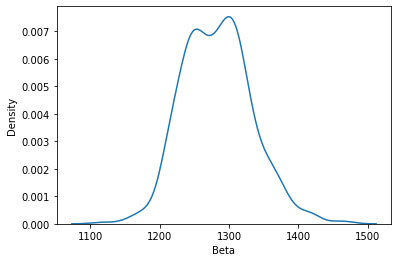

In [83]:
# Beta distribution showing a good approximate normal distribution which made us beleieve that 
# the nan values can be filled by median without any problem
sns.kdeplot(train['Beta'])

In [85]:
## Gamma feature visualisation
print(train['Gamma'].value_counts())
print(test['Gamma'].value_counts())

3    383
1    145
2     74
Name: Gamma, dtype: int64
3    247
1    116
2     47
Name: Gamma, dtype: int64


<AxesSubplot:xlabel='Gamma', ylabel='count'>

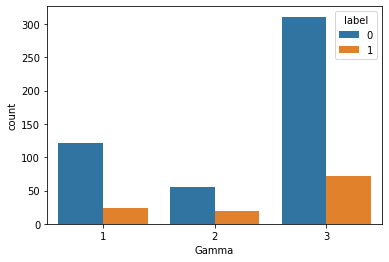

In [86]:
sns.countplot(x='Gamma', data= train,hue='label')

<AxesSubplot:xlabel='Eta', ylabel='count'>

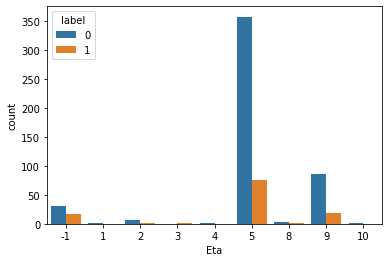

In [88]:
# Eta visualisation
sns.countplot(x='Eta', data= train,hue='label')

<AxesSubplot:xlabel='Zeta', ylabel='count'>

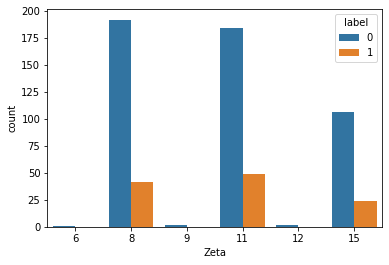

In [89]:
# Zeta visualisation
sns.countplot(x='Zeta', data= train,hue='label')

**Some cells which we ran for annalysing and taking intutition about the aggregated feature me made**

In [ ]:
train_meta[(train_meta.last_update.isnull())|(train_meta.recent_payment_activity.isnull())]["normal_payment"].min()

In [ ]:
train_meta[train_meta['last_update'].isnull()].groupby("id").size()

In [ ]:
train_meta[train_meta.id==3730406]

In [ ]:
train[train.id==3730406]

In [ ]:
train_meta.lu_date

In [ ]:
train_meta.sort_values(["id","lu_year","lu_month", "lu_date"])[train_meta.sort_values(["id","lu_year" ,"lu_month", "lu_date"]).id ==]

In [ ]:
train_meta['p_limit'].max()

In [ ]:
train_meta.sort_values(["id","lu_year","lu_month", "lu_date"]).groupby("id")["p_limit"].apply(lambda x: x.bfill()+1000)

# Data Preprocessing and Transformation (Actual and Advanced preprocessing start here)

**In this section we had done three things**

1. Flled nan values of payment.csv and other datas by analysing those features, the description on how we done it can make the comments ver long for this notebook to address. we can describe if needed before second round selection.

2. Aggregating from payment.csv and concateing into original data, Now how we made those features is a combination of outputs we got from above cells and some other analysis which can be described in a well expained manner later.

3. Now made aggregations within the data resulted from part-2 on some basis


In [100]:
## Converting date features to pd.to_datetime
train_meta['last_update'] = pd.to_datetime(train_meta['last_update'], dayfirst=True)
train_meta['recent_payment_activity'] = pd.to_datetime(train_meta['recent_payment_activity'], dayfirst=True)
train_meta['lu_month'] = train_meta['last_update'].dt.month
train_meta['lu_date'] = train_meta['last_update'].dt.day
train_meta['lu_year'] = train_meta['last_update'].dt.year

### Filling nans

In [101]:
train_meta = train_meta.sort_values(["id","lu_year","lu_month", "lu_date"]).reset_index(drop = True) # sorted
# drooping these lu columns
train_meta.drop(columns=  ["lu_month", "lu_year", "lu_date"], inplace = True)

In [102]:
# fillings values in train_meta
dt1 = pd.to_datetime("30/12/2016", dayfirst = True) # for above 30/12/2016
dt2 = pd.to_datetime("28/02/2017", dayfirst = True) # for recent activity greater than this
dt3 = pd.to_datetime("01/08/2015", dayfirst = True) # for update onlt 2 of this type
dt4 = pd.to_datetime("01/01/2021", dayfirst = True) # for update onlt 2 of this type
train_meta['max_bal'].fillna(0, inplace = True)### Filling max_balance with 0 in meta_data
train_meta["p_limit"] = train_meta.groupby("id")["p_limit"].ffill() #using ffill for filling 66 % data
train_meta["last_update"][(train_meta.last_update.isnull())&(train_meta.recent_payment_activity.isnull())] = train_meta["last_update"][(train_meta.last_update.isnull())&(train_meta.recent_payment_activity.isnull())].fillna(dt1)
train_meta["recent_payment_activity"][(train_meta.last_update.isnull())&(train_meta.recent_payment_activity.isnull())] = train_meta["recent_payment_activity"][(train_meta.last_update.isnull())&(train_meta.recent_payment_activity.isnull())].fillna(dt1)
train_meta["last_update"][(train_meta.last_update.isnull())&(~train_meta.recent_payment_activity.isnull())] = train_meta["last_update"][(train_meta.last_update.isnull())&(~train_meta.recent_payment_activity.isnull())].fillna(dt3)
train_meta["recent_payment_activity"][(~train_meta.last_update.isnull())&(train_meta.recent_payment_activity.isnull())] = train_meta["recent_payment_activity"][(~train_meta.last_update.isnull())&(train_meta.recent_payment_activity.isnull())].fillna(dt4)
train_meta["p_limit"] = train_meta.groupby("id")["p_limit"].apply(lambda x: x.bfill().ffill()+1000)
train_meta["p_limit"].fillna(400000, inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/sit

In [103]:
train_meta.isnull().sum()

id                         0
Late_2                     0
Late_1                     0
Late_3                     0
days_late_Sum              0
normal_payment             0
p_code                     0
p_limit                    0
last_update                0
curr_remaining             0
max_bal                    0
recent_payment_activity    0
dtype: int64

### Modifying original demographics data and fill nans of it


In [104]:
# Concatenated both dataset train and test
Y_train = train['label']
dataset = pd.concat([train.drop(columns = ['label']), test]).reset_index(drop = True)

In [105]:
dataset.isnull().sum()

id           0
Alpha        0
Beta       149
Gamma        0
Delta        0
Epsilon      0
Zeta         0
Eta          0
Theta        0
Iota         0
Kappa        0
Lambda       0
omikron      0
dtype: int64

So it sounds reasonable to replace the nans with mean value of it


In [107]:
# filling beta feature with median which we described earlier why we do it
med = dataset['Beta'].median()
dataset['Beta'].fillna(med, inplace = True)

### Modifying Train data features

In [109]:
dataset['Alpha'] = dataset['Alpha']//523  # as already mentioned divided by 523
dataset["Del_bins"] = (dataset['Delta']//1000).map(lambda x: 1 if x< 70 else 2 if x<250 else 3)  # biining the delta function into three based on its distribition
dataset["Theta"]  = dataset['Theta'].map(lambda x: 1 if x< 70 else 2 if x <80 else 3 if x<90 else 4 if x<100 else 5 if x<110 else 6) # Similarly Binning theta function which we hypothised as ages into discrete age group.

# Aggregation type1

**Within payment_history.csv**

1. curr_remaining-max_ball>0 feature agg in terms of everyhting(both as a category label and numerical label)
2. variation of product limits how freuently changes(montonocity in this as well)
3. monotnicity in curr_balance and max_bal
4. days late sum aggregation
5. amount of each late type aggregate
6. ratios of 4th, 5th
7. number of normal_payments/per_unit_time
8. binning of days_late_sum

## Aggregation1 starts from here (for making features from payment history)

In [110]:
train_meta['days_per_session'] = (train_meta['recent_payment_activity'].dt.year-train_meta['last_update'].dt.year)*12 + (train_meta['recent_payment_activity'].dt.month-train_meta['last_update'].dt.month)+1
train_meta['late_per_session'] = train_meta['days_late_Sum']/train_meta['days_per_session']
train_meta["diff_bw_upd_pay"] = train_meta['recent_payment_activity'].dt.year-train_meta['last_update'].dt.year
agg_trans1 = train_meta.groupby('id')[["Late_2", "Late_3", "Late_1", "days_late_Sum", "normal_payment"]].agg(['mean','std'])
agg_trans1.columns = ['_'.join(col).strip() for col in agg_trans1.columns.values]
agg_trans1.reset_index(inplace=True)

df = train_meta.groupby('id').size().reset_index(name='transactions_count')
agg_trans1 = pd.merge(df, agg_trans1, on='id', how='left')


train_meta["p_limit_decr"] = (train_meta.groupby('id')['p_limit'].diff().reset_index(drop=True)<0).map(lambda x:1 if x else 0 if np.isnan(x) else 0)

train_meta["curr_greater_prev_max_bal"] = (train_meta.curr_remaining- train_meta.max_bal>0).map(lambda x:1 if x else 0)
agg_trans2 = train_meta.groupby('id')[["p_limit_decr", "curr_greater_prev_max_bal", "late_per_session", "diff_bw_upd_pay"]].agg(['mean','std'])

agg_trans2.columns = ['_'.join(col).strip() for col in agg_trans2.columns.values]
agg_trans2.reset_index(inplace=True)
agg_trans = pd.merge(agg_trans1, agg_trans2, on='id', how='left')

In [111]:
train[train.id.isin(dataset.sort_values("id")[(train_meta.groupby("id").tail(1).sort_values("id")["curr_remaining"]>100000).values].id)]["label"].value_counts()

0    111
1     20
Name: label, dtype: int64

In [112]:
train[train.id.isin(dataset.sort_values("id")[(train_meta.groupby("id").tail(1).sort_values("id")["curr_remaining"]>1000).values].id)]

,label,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,omikron
2,0,1489815797,2092,1244.0,3,107000,2,8,5,112,5,60017,3.162278,0.026786
3,0,1489759034,2092,1364.0,3,194000,2,8,5,110,5,151004,223.606798,0.027273
4,0,1486529479,3661,1289.0,3,305000,1,11,5,110,5,60033,236.643191,0.027273
5,1,1487734487,3661,1382.0,3,115000,2,11,5,100,5,60058,1.000000,0.030000
9,0,2233421,3661,1295.0,1,116000,2,11,9,108,4,151300,1.000000,0.009259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0,1485631659,2615,NaN,2,82000,2,15,5,106,5,60058,1.000000,0.018868
711,0,1487505580,3661,1326.5,1,141000,2,11,-1,67,5,60007,1.000000,0.014925
712,0,1492854287,2092,NaN,2,111000,2,8,5,110,4,60091,220.868739,0.018182
713,0,1492283318,2092,1370.0,1,273000,2,8,9,110,5,60015,1.000000,0.009091


In [113]:
train_meta[train_meta.id==1114]

,id,Late_2,Late_1,Late_3,days_late_Sum,normal_payment,p_code,p_limit,last_update,curr_remaining,max_bal,recent_payment_activity,days_per_session,late_per_session,diff_bw_upd_pay,p_limit_decr,curr_greater_prev_max_bal
18,1114,0,0,0,0,36,10,331000.0,1998-06-17,6.0,81139.0,2013-05-10,180,0.0,15,0,0
19,1114,0,0,0,0,18,12,331000.0,1998-10-02,0.0,31666.0,2006-06-28,93,0.0,8,0,0
20,1114,0,0,0,0,0,6,331000.0,2001-01-14,0.0,18000.0,2021-01-01,241,0.0,20,0,0
21,1114,0,0,0,0,10,6,331000.0,2001-01-14,0.0,16000.0,2021-01-01,241,0.0,20,0,0
22,1114,0,0,0,0,36,10,331000.0,2006-03-30,15938.4,28740.0,2015-11-26,117,0.0,9,0,0
23,1114,0,0,0,0,1,27,331000.0,2006-06-19,0.0,600500.0,2010-10-26,53,0.0,4,0,0
24,1114,0,0,0,0,16,27,331000.0,2006-06-19,0.0,600500.0,2021-01-01,176,0.0,15,0,0


In [24]:
train_meta.groupby("id").tail(1).sort_values("id")["curr_remaining"]<=0

17       True
28      False
30      False
34       True
44      False
        ...  
7051    False
7055    False
7063     True
7066    False
7069    False
Name: curr_remaining, Length: 1012, dtype: bool

**Combining both data payment history and original based on agg features**

In [114]:
full_df = pd.merge(dataset, agg_trans, on='id', how='left')

In [116]:
full_df.fillna(-1, inplace = True)  # Filling some nan values if there is any obtained from mathematical 
                                    # faults like divide by 0 likewise ith -1 to make it explicit

In [117]:
full_df

,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,...,normal_payment_mean,normal_payment_std,p_limit_decr_mean,p_limit_decr_std,curr_greater_prev_max_bal_mean,curr_greater_prev_max_bal_std,late_per_session_mean,late_per_session_std,diff_bw_upd_pay_mean,diff_bw_upd_pay_std
0,1484006679,1,1281.5,2,500000,2,5,-1,2,5,...,13.333333,14.449494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.166667,6.336522
1,1489825072,4,1250.0,3,137000,2,8,5,4,5,...,25.125000,14.156649,0.125000,0.353553,0.000000,0.000000,0.002976,0.008418,4.000000,3.817254
2,1489815797,4,1244.0,3,107000,2,8,5,6,5,...,16.142857,7.335498,0.142857,0.377964,0.142857,0.377964,0.000000,0.000000,0.857143,0.899735
3,1489759034,4,1364.0,3,194000,2,8,5,6,5,...,15.750000,10.180514,0.000000,0.000000,0.125000,0.353553,0.000000,0.000000,1.375000,2.722263
4,1486529479,7,1289.0,3,305000,1,11,5,6,5,...,12.727273,11.849818,0.090909,0.301511,0.181818,0.404520,8.253961,17.825034,2.727273,2.760105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,1489702642,4,1313.0,3,134000,2,8,5,5,3,...,22.909091,14.046028,0.272727,0.467099,0.000000,0.000000,0.010250,0.031172,8.272727,5.728716
1121,1835338,7,1125.5,3,79000,2,11,-1,5,5,...,16.750000,12.685293,0.000000,0.000000,0.250000,0.500000,0.395427,0.523094,1.250000,1.500000
1122,1236915,7,1188.5,3,90000,2,11,5,4,5,...,11.500000,7.852813,0.000000,0.000000,0.250000,0.500000,0.785714,1.571429,1.250000,1.258306
1123,1489208099,7,1386.5,1,165000,2,11,-1,5,3,...,23.000000,9.643651,0.200000,0.447214,0.200000,0.447214,0.000000,0.000000,1.200000,1.095445


## AGGREGATION TYPE2

Let'us use some of the categorical datas to generate features which can be used by tree based models.
Here used groupby on the above generated data to made features which can be benefical in making best split for a model like xgboost of LGBM with more depth.

In [118]:
full_df["mean_late_days_per_delta_week"] = full_df.groupby(["Del_bins", "Alpha"])["late_per_session_mean"].transform("mean")
full_df["late_vs_epsilon"] = full_df.groupby(["Epsilon"])["late_per_session_mean"].transform("mean")
#full_df["beta_bins"] = full_df.groupby(["Del_bins"])["Beta"].transform("mean")
full_df["payments_regions"] = full_df.groupby(["Gamma", "Del_bins", "Epsilon"])["normal_payment_mean"].transform("sum")
#full_df["bal_incre_region"] = full_df.groupby(["Gamma"])["max_bal_incr_mean"].transform("sum")
full_df["limit_dec_region"] = full_df.groupby(["Gamma"])["p_limit_decr_mean"].transform("sum")
#full_df["total_days_per_days_update"] = full_df.groupby(["Alpha"])["days_per_session_mean"].transform("mean")
#full_df["kappa_per_bin"] = full_df.groupby(["Del_bins"])["Kappa"].transform("mean")

full_df["delta_per_theta"] = full_df.groupby(["Theta"])["Delta"].transform("mean")
#full_df["late_per_theta"] = full_df.groupby(["Theta"])["Late_3_mean"].transform("mean")

In [30]:
full_df

,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,...,diff_bw_upd_pay_mean,diff_bw_upd_pay_std,mean_late_days_per_delta_week,late_vs_epsilon,beta_bins,payments_regions,bal_incre_region,limit_dec_region,total_days_per_days_update,delta_per_theta
0,1489825072,4,1250.0,3,137000,2,8,5,4,5,...,4.000000,3.817254,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,115893.129771
1,1489815797,4,1244.0,3,107000,2,8,5,6,5,...,0.857143,0.899735,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,107848.837209
2,1489759034,4,1364.0,3,194000,2,8,5,6,5,...,1.375000,2.722263,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,107848.837209
3,1487734487,7,1382.0,3,115000,2,11,5,5,5,...,4.166667,2.136976,5.878214,3.949673,1289.836376,5747.087156,229.968746,28.650335,30.964916,114717.460317
4,2959839,4,1314.5,1,177000,2,8,-1,6,5,...,2.500000,1.914854,-0.012682,3.949673,1289.836376,3021.218784,91.594112,12.963645,29.693415,107848.837209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1489702642,4,1313.0,3,134000,2,8,5,5,3,...,8.272727,5.728716,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,114717.460317
1008,1835338,7,1125.5,3,79000,2,11,-1,5,5,...,1.250000,1.500000,5.878214,3.949673,1289.836376,5747.087156,229.968746,28.650335,30.964916,114717.460317
1009,1236915,7,1188.5,3,90000,2,11,5,4,5,...,1.250000,1.258306,5.878214,3.949673,1289.836376,5747.087156,229.968746,28.650335,30.964916,115893.129771
1010,1489208099,7,1386.5,1,165000,2,11,-1,5,3,...,1.200000,1.095445,5.878214,3.949673,1289.836376,3021.218784,91.594112,12.963645,30.964916,114717.460317


In [31]:
train_meta

,id,Late_2,Late_1,Late_3,days_late_Sum,normal_payment,p_code,p_limit,last_update,curr_remaining,max_bal,recent_payment_activity,days_per_session,late_per_session,diff_bw_upd_pay,p_limit_decr,max_bal_incr,curr_greater_prev_max_bal
0,1,0,0,0,0,0,10,276000.0,1994-12-18,13909.2,0.0,2021-01-01,314,0.000000,27,0,0,1
1,1,1,0,0,15,35,10,276000.0,1997-04-21,-1197.6,333140.0,2015-07-21,220,0.068182,18,0,1,0
2,1,0,0,0,0,11,2,276000.0,2001-02-21,0.0,248874.0,2007-06-22,77,0.000000,6,0,0,0
3,1,0,0,0,0,35,10,6500.0,2003-01-05,0.0,4043.0,2003-11-25,11,0.000000,0,1,0,0
4,1,0,0,0,0,4,10,6500.0,2003-09-17,0.0,4458.0,2006-03-28,31,0.000000,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7065,1492854287,1,0,0,28,35,10,34000.0,2013-01-28,9956.4,22591.0,2016-02-04,38,0.736842,3,0,0,0
7066,1492854287,0,0,0,0,10,5,34000.0,2015-04-05,528427.2,500500.0,2016-02-21,11,0.000000,1,0,1,1
7067,1492861707,0,0,0,0,19,10,16400.0,2014-02-07,0.0,13901.0,2015-11-14,22,0.000000,1,0,0,0
7068,1492861707,0,0,0,0,1,6,16400.0,2015-02-14,0.0,21000.0,2015-10-22,9,0.000000,0,0,1,0


In [32]:
full_df

,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,...,diff_bw_upd_pay_mean,diff_bw_upd_pay_std,mean_late_days_per_delta_week,late_vs_epsilon,beta_bins,payments_regions,bal_incre_region,limit_dec_region,total_days_per_days_update,delta_per_theta
0,1489825072,4,1250.0,3,137000,2,8,5,4,5,...,4.000000,3.817254,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,115893.129771
1,1489815797,4,1244.0,3,107000,2,8,5,6,5,...,0.857143,0.899735,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,107848.837209
2,1489759034,4,1364.0,3,194000,2,8,5,6,5,...,1.375000,2.722263,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,107848.837209
3,1487734487,7,1382.0,3,115000,2,11,5,5,5,...,4.166667,2.136976,5.878214,3.949673,1289.836376,5747.087156,229.968746,28.650335,30.964916,114717.460317
4,2959839,4,1314.5,1,177000,2,8,-1,6,5,...,2.500000,1.914854,-0.012682,3.949673,1289.836376,3021.218784,91.594112,12.963645,29.693415,107848.837209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1489702642,4,1313.0,3,134000,2,8,5,5,3,...,8.272727,5.728716,-0.012682,3.949673,1289.836376,5747.087156,229.968746,28.650335,29.693415,114717.460317
1008,1835338,7,1125.5,3,79000,2,11,-1,5,5,...,1.250000,1.500000,5.878214,3.949673,1289.836376,5747.087156,229.968746,28.650335,30.964916,114717.460317
1009,1236915,7,1188.5,3,90000,2,11,5,4,5,...,1.250000,1.258306,5.878214,3.949673,1289.836376,5747.087156,229.968746,28.650335,30.964916,115893.129771
1010,1489208099,7,1386.5,1,165000,2,11,-1,5,3,...,1.200000,1.095445,5.878214,3.949673,1289.836376,3021.218784,91.594112,12.963645,30.964916,114717.460317


In [119]:
full_df = pd.merge(full_df, train_meta.groupby("id").tail(1)[["id", "curr_remaining"]], how = "left", on= "id")

In [120]:
full_df.drop(columns = ["id"], inplace=True)

In [35]:
train_meta.sort_values("id")[(train_meta.sort_values("id").max_bal.isnull())&(train_meta.sort_values("id").curr_remaining>0)]

,id,Late_2,Late_1,Late_3,days_late_Sum,normal_payment,p_code,p_limit,last_update,curr_remaining,max_bal,recent_payment_activity,days_per_session,late_per_session,diff_bw_upd_pay,p_limit_decr,max_bal_incr,curr_greater_prev_max_bal


In [36]:
train[train.id.isin(train_meta.sort_values("id")[(train_meta.sort_values("id").max_bal.isnull())&(train_meta.sort_values("id").curr_remaining>0)].groupby("id").size().reset_index()['id'].values)]

,label,id,Alpha,Beta,Gamma,Delta,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,omikron


In [ ]:
train_meta[x]['curr_remaining']

In [137]:
full_df.nunique()

Alpha                               6
Beta                              158
Gamma                               3
Delta                             229
Epsilon                             2
Eta                                10
Theta                               6
Kappa                             280
Lambda                            266
omikron                           125
Del_bins                            3
transactions_count                 37
Late_2_mean                       124
Late_2_std                        237
Late_3_mean                       108
Late_3_std                        136
Late_1_mean                        95
Late_1_std                        146
days_late_Sum_mean                366
days_late_Sum_std                 398
days_per_session_mean             730
days_per_session_std              981
normal_payment_mean               538
normal_payment_std                918
p_limit_decr_mean                  48
p_limit_decr_std                   93
max_bal_incr

Now some tree based models like lgbm and xgboost accept features of as type categorical and treates those features specifically compared to numerical and give them treatment like categories and we not need to do seprate one hot encodings for them.

In [121]:
# we selected these features to treat it as categorical
categorical_cols = ['Del_bins',  'Gamma', "Eta", "Theta", "Epsilon"]

In [38]:
# converting to astype category
for i in categorical_cols:
    full_df[i] = full_df[i].astype("category")

In [140]:
full_df.isnull().sum()

Alpha                             0
Beta                              0
Gamma                             0
Delta                             0
Epsilon                           0
Eta                               0
Theta                             0
Kappa                             0
Lambda                            0
omikron                           0
Del_bins                          0
transactions_count                0
Late_2_mean                       0
Late_2_std                        0
Late_3_mean                       0
Late_3_std                        0
Late_1_mean                       0
Late_1_std                        0
days_late_Sum_mean                0
days_late_Sum_std                 0
days_per_session_mean             0
days_per_session_std              0
normal_payment_mean               0
normal_payment_std                0
p_limit_decr_mean                 0
p_limit_decr_std                  0
max_bal_incr_mean                 0
max_bal_incr_std            

# MODEL BUILDING

Here we preformed several techniques for hyperparameter tuning and tested different models

We found **Optuna** to be the best tool for yperparameter optimization instead of Random and Grid Search CV in terms of transversing the hyperparameter space.

For model we tried different models but as the training and testing have no correlation we found that the model performing well on cross validation on training giving bad on leaderboard, it signifies there is less correlation on the distribution and we had done cross validation so there is no point of overfitting type of thing for justifying why we move to the below in leaderboard it is just the lack of trust in crossvalidation

So on basis of consistent result we used **LGBM(Light Gradient Boosting Method)**
**Even we adopted SMOTE, oversampling techinque to make equal distribution but still problem of correlation between train and test data is there**

In [122]:
# Getting the dataset back
x_train, x_test = full_df[0:len(train)], full_df[len(train):]

In [123]:
# using optuna
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

#category_cols = ['disrict', 'client_catg', 'region', 'region_group']

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,x_train,Y_train)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore

In [125]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(random_state = 44)
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':44
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    model = LGBMClassifier(**params, categorical_features = "auto")
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, preds[:,1])
        # may differ
        print (auc(false_positive_rate, true_positive_rate))
        res.append(auc(false_positive_rate, true_positive_rate))
    err = np.mean(res)
    
    return model, err

In [126]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective,None , timeout=60*60*2)

[I 2021-04-12 13:20:43,193] A new study created in memory with name: no-name-ca9b7ec4-6df1-44c3-a343-9cd5107bc7c3
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


0.7739130434782608
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39309985076157594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39309985076157594
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7380434782608696
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39309985076157594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39309985076157594
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6402173913043478
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39309985076157594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39309985076157594
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored

[I 2021-04-12 13:20:43,826] Trial 0 finished with value: 0.6990579710144929 and parameters: {'n_estimators': 265, 'num_leaves': 64, 'max_depth': 19, 'learning_rate': 0.039032243371170866, 'min_split_gain': 0.03869279854056714, 'feature_fraction': 0.39309985076157594, 'bagging_freq': 7}. Best is trial 0 with value: 0.6990579710144929.


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39309985076157594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39309985076157594
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7018115942028985


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5104922737149502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104922737149502
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7579710144927536
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5104922737149502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104922737149502
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7376811594202899
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5104922737149502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104922737149502
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:44,376] Trial 1 finished with value: 0.6849637681159421 and parameters: {'n_estimators': 884, 'num_leaves': 13, 'max_depth': 17, 'learning_rate': 0.030532097318654722, 'min_split_gain': 0.0013875330158273126, 'feature_fraction': 0.5104922737149502, 'bagging_freq': 6}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.700711189656274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.700711189656274
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7641304347826088
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.700711189656274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.700711189656274
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7141304347826087
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.700711189656274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.700711189656274
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

[I 2021-04-12 13:20:46,163] Trial 2 finished with value: 0.6789855072463767 and parameters: {'n_estimators': 320, 'num_leaves': 234, 'max_depth': 55, 'learning_rate': 0.0033418627409586396, 'min_split_gain': 0.0017849151436314073, 'feature_fraction': 0.700711189656274, 'bagging_freq': 0}. Best is trial 0 with value: 0.6990579710144929.


0.6804347826086957


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14176012403928095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14176012403928095
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7702898550724638
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14176012403928095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14176012403928095
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7246376811594203
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14176012403928095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14176012403928095
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:20:46,667] Trial 3 finished with value: 0.6514492753623188 and parameters: {'n_estimators': 377, 'num_leaves': 429, 'max_depth': 47, 'learning_rate': 0.060330950619222744, 'min_split_gain': 0.0039177665309687365, 'feature_fraction': 0.14176012403928095, 'bagging_freq': 0}. Best is trial 0 with value: 0.6990579710144929.


0.5721014492753622
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14176012403928095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14176012403928095
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.5826086956521739


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.573791774650503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.573791774650503
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7677536231884058
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.573791774650503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.573791774650503
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7170289855072465
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.573791774650503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.573791774650503
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

[I 2021-04-12 13:20:47,294] Trial 4 finished with value: 0.6804347826086957 and parameters: {'n_estimators': 466, 'num_leaves': 466, 'max_depth': 92, 'learning_rate': 0.02188643923448543, 'min_split_gain': 0.08429098242286057, 'feature_fraction': 0.573791774650503, 'bagging_freq': 9}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.408311226781658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.408311226781658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7576086956521739
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.408311226781658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.408311226781658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.743840579710145
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.408311226781658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.408311226781658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-04-12 13:20:47,881] Trial 5 finished with value: 0.6869565217391305 and parameters: {'n_estimators': 947, 'num_leaves': 245, 'max_depth': 72, 'learning_rate': 0.030741553519713832, 'min_split_gain': 0.0010376142090080887, 'feature_fraction': 0.408311226781658, 'bagging_freq': 9}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22026823913982937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22026823913982937
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7782608695652173
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22026823913982937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22026823913982937
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7427536231884058
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22026823913982937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22026823913982937
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:20:48,387] Trial 6 finished with value: 0.6736956521739129 and parameters: {'n_estimators': 57, 'num_leaves': 89, 'max_depth': 92, 'learning_rate': 0.007153069181724517, 'min_split_gain': 0.0033864190909085527, 'feature_fraction': 0.22026823913982937, 'bagging_freq': 0}. Best is trial 0 with value: 0.6990579710144929.


0.6054347826086957
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22026823913982937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22026823913982937
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.6619565217391303


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.8375878487283657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8375878487283657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7318840579710145
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.8375878487283657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8375878487283657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.736231884057971
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.8375878487283657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8375878487283657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2021-04-12 13:20:48,882] Trial 7 finished with value: 0.6719565217391306 and parameters: {'n_estimators': 653, 'num_leaves': 341, 'max_depth': 115, 'learning_rate': 0.14851703729250715, 'min_split_gain': 0.004836628830991963, 'feature_fraction': 0.8375878487283657, 'bagging_freq': 7}. Best is trial 0 with value: 0.6990579710144929.


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.8375878487283657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8375878487283657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6644927536231884


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.21894732205957929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21894732205957929
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.7815217391304348
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.21894732205957929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21894732205957929
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.7278985507246377
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.21894732205957929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21894732205957929
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:20:49,773] Trial 8 finished with value: 0.671304347826087 and parameters: {'n_estimators': 189, 'num_leaves': 112, 'max_depth': 78, 'learning_rate': 0.002736935753977978, 'min_split_gain': 0.00637280976974754, 'feature_fraction': 0.21894732205957929, 'bagging_freq': 3}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7350966184718217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7350966184718217
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7514492753623189
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7350966184718217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7350966184718217
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7170289855072465
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7350966184718217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7350966184718217
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:50,549] Trial 9 finished with value: 0.6758695652173914 and parameters: {'n_estimators': 346, 'num_leaves': 409, 'max_depth': 22, 'learning_rate': 0.01587872858931728, 'min_split_gain': 0.0025943030427176147, 'feature_fraction': 0.7350966184718217, 'bagging_freq': 4}. Best is trial 0 with value: 0.6990579710144929.


0.6844202898550725


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38106362109202985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38106362109202985
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7387681159420291
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38106362109202985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38106362109202985
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7164855072463768
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38106362109202985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38106362109202985
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:20:50,933] Trial 10 finished with value: 0.6637318840579711 and parameters: {'n_estimators': 20, 'num_leaves': 4, 'max_depth': 3, 'learning_rate': 0.13538922816381466, 'min_split_gain': 0.031806987463719336, 'feature_fraction': 0.38106362109202985, 'bagging_freq': 7}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3579219104289127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3579219104289127
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.761231884057971
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3579219104289127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3579219104289127
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.744927536231884
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3579219104289127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3579219104289127
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_fr

[I 2021-04-12 13:20:51,490] Trial 11 finished with value: 0.6989130434782609 and parameters: {'n_estimators': 917, 'num_leaves': 221, 'max_depth': 41, 'learning_rate': 0.05641666686452752, 'min_split_gain': 0.02028900262593613, 'feature_fraction': 0.3579219104289127, 'bagging_freq': 9}. Best is trial 0 with value: 0.6990579710144929.


0.625
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3579219104289127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3579219104289127
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7039855072463768


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35848317815796954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35848317815796954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7405797101449275
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35848317815796954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35848317815796954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7275362318840579
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35848317815796954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35848317815796954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:20:52,013] Trial 12 finished with value: 0.6872463768115942 and parameters: {'n_estimators': 670, 'num_leaves': 133, 'max_depth': 33, 'learning_rate': 0.06843239705631642, 'min_split_gain': 0.022627524676648414, 'feature_fraction': 0.35848317815796954, 'bagging_freq': 9}. Best is trial 0 with value: 0.6990579710144929.


0.6413043478260869
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35848317815796954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35848317815796954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7018115942028986


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2881808424449254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2881808424449254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7746376811594202
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2881808424449254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2881808424449254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7163043478260869
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2881808424449254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2881808424449254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:52,560] Trial 13 finished with value: 0.6860144927536233 and parameters: {'n_estimators': 686, 'num_leaves': 190, 'max_depth': 37, 'learning_rate': 0.06193286589049885, 'min_split_gain': 0.01884364578205177, 'feature_fraction': 0.2881808424449254, 'bagging_freq': 7}. Best is trial 0 with value: 0.6990579710144929.


0.6318840579710144
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2881808424449254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2881808424449254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.691304347826087


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5217259179867012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5217259179867012
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7681159420289856
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5217259179867012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5217259179867012
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7054347826086956
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5217259179867012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5217259179867012
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:53,450] Trial 14 finished with value: 0.6785507246376812 and parameters: {'n_estimators': 166, 'num_leaves': 330, 'max_depth': 8, 'learning_rate': 0.00672474302446209, 'min_split_gain': 0.06753956265948292, 'feature_fraction': 0.5217259179867012, 'bagging_freq': 5}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4565027883170921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4565027883170921
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.826086956521739
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4565027883170921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4565027883170921
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7492753623188406
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4565027883170921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4565027883170921
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2021-04-12 13:20:53,943] Trial 15 finished with value: 0.6906884057971014 and parameters: {'n_estimators': 809, 'num_leaves': 42, 'max_depth': 28, 'learning_rate': 0.09298250805477247, 'min_split_gain': 0.011720428158777453, 'feature_fraction': 0.4565027883170921, 'bagging_freq': 8}. Best is trial 0 with value: 0.6990579710144929.


0.6782608695652174


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.10356157996702031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10356157996702031
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
0.7670289855072464
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.10356157996702031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10356157996702031
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
0.6974637681159419
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.10356157996702031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10356157996702031
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:20:54,483] Trial 16 finished with value: 0.655072463768116 and parameters: {'n_estimators': 198, 'num_leaves': 189, 'max_depth': 53, 'learning_rate': 0.03542268814459767, 'min_split_gain': 0.042974656412146144, 'feature_fraction': 0.10356157996702031, 'bagging_freq': 2}. Best is trial 0 with value: 0.6990579710144929.


0.5971014492753625
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.10356157996702031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10356157996702031
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
0.631159420289855


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.6367947659482023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6367947659482023
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7554347826086957
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.6367947659482023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6367947659482023
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7409420289855072
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.6367947659482023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6367947659482023
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:55,184] Trial 17 finished with value: 0.6835869565217391 and parameters: {'n_estimators': 562, 'num_leaves': 318, 'max_depth': 2, 'learning_rate': 0.010253385888437123, 'min_split_gain': 0.010526260652958946, 'feature_fraction': 0.6367947659482023, 'bagging_freq': 8}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.9801641990656074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9801641990656074
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7721014492753624
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.9801641990656074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9801641990656074
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7329710144927537
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.9801641990656074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9801641990656074
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:55,785] Trial 18 finished with value: 0.6775 and parameters: {'n_estimators': 505, 'num_leaves': 165, 'max_depth': 40, 'learning_rate': 0.04072414856359005, 'min_split_gain': 0.04765706534607614, 'feature_fraction': 0.9801641990656074, 'bagging_freq': 5}. Best is trial 0 with value: 0.6990579710144929.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.26423752164864267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26423752164864267
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.8021739130434783
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.26423752164864267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26423752164864267
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.716304347826087
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.26423752164864267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26423752164864267
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:20:58,654] Trial 19 finished with value: 0.6778260869565218 and parameters: {'n_estimators': 789, 'num_leaves': 61, 'max_depth': 16, 'learning_rate': 0.0013871399823037385, 'min_split_gain': 0.01670082038874214, 'feature_fraction': 0.26423752164864267, 'bagging_freq': 8}. Best is trial 0 with value: 0.6990579710144929.


0.686231884057971


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3346149097566225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3346149097566225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7782608695652173
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3346149097566225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3346149097566225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.688768115942029
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3346149097566225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3346149097566225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2021-04-12 13:20:59,172] Trial 20 finished with value: 0.6815942028985507 and parameters: {'n_estimators': 115, 'num_leaves': 290, 'max_depth': 70, 'learning_rate': 0.09533892717768488, 'min_split_gain': 0.03553567076121872, 'feature_fraction': 0.3346149097566225, 'bagging_freq': 6}. Best is trial 0 with value: 0.6990579710144929.


0.6630434782608696


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4739033556097208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4739033556097208
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.8170289855072463
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4739033556097208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4739033556097208
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7510869565217392
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4739033556097208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4739033556097208
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:20:59,683] Trial 21 finished with value: 0.7090579710144927 and parameters: {'n_estimators': 966, 'num_leaves': 52, 'max_depth': 28, 'learning_rate': 0.10515998674942041, 'min_split_gain': 0.010137122280832698, 'feature_fraction': 0.4739033556097208, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6844202898550724


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4516711655092751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4516711655092751
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.8054347826086956
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4516711655092751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4516711655092751
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7028985507246377
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4516711655092751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4516711655092751
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:00,161] Trial 22 finished with value: 0.6824275362318841 and parameters: {'n_estimators': 975, 'num_leaves': 79, 'max_depth': 26, 'learning_rate': 0.1488693561403073, 'min_split_gain': 0.00873459361095549, 'feature_fraction': 0.4516711655092751, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44255507407955197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44255507407955197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7684782608695652
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44255507407955197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44255507407955197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7304347826086957
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44255507407955197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44255507407955197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:00,722] Trial 23 finished with value: 0.6877536231884058 and parameters: {'n_estimators': 989, 'num_leaves': 149, 'max_depth': 45, 'learning_rate': 0.04739941352263922, 'min_split_gain': 0.026279827210564426, 'feature_fraction': 0.44255507407955197, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


0.6025362318840579
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44255507407955197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44255507407955197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.6681159420289855


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5788877652726364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788877652726364
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7757246376811595
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5788877652726364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788877652726364
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7173913043478262
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5788877652726364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788877652726364
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:01,245] Trial 24 finished with value: 0.668804347826087 and parameters: {'n_estimators': 847, 'num_leaves': 43, 'max_depth': 58, 'learning_rate': 0.10055054408437171, 'min_split_gain': 0.013762176556976586, 'feature_fraction': 0.5788877652726364, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.5728260869565217
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5788877652726364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788877652726364
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.6483695652173913


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2969850420662254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2969850420662254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7876811594202898
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2969850420662254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2969850420662254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7405797101449275
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2969850420662254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2969850420662254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:01,835] Trial 25 finished with value: 0.6997101449275362 and parameters: {'n_estimators': 278, 'num_leaves': 5, 'max_depth': 10, 'learning_rate': 0.0174521295499316, 'min_split_gain': 0.007488637481560341, 'feature_fraction': 0.2969850420662254, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.19354626034885214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19354626034885214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7655797101449275
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.19354626034885214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19354626034885214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7297101449275363
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.19354626034885214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19354626034885214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:02,420] Trial 26 finished with value: 0.683695652173913 and parameters: {'n_estimators': 229, 'num_leaves': 8, 'max_depth': 12, 'learning_rate': 0.024473192046112015, 'min_split_gain': 0.00811032636423595, 'feature_fraction': 0.19354626034885214, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6380434782608695
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.19354626034885214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19354626034885214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6010869565217392
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.19354626034885214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19354626034885214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6840579710144927


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.30227893853431564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30227893853431564
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7855072463768116
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.30227893853431564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30227893853431564
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.721376811594203
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.30227893853431564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30227893853431564
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:03,144] Trial 27 finished with value: 0.6858695652173913 and parameters: {'n_estimators': 263, 'num_leaves': 100, 'max_depth': 7, 'learning_rate': 0.015477544563126954, 'min_split_gain': 0.006049242225016753, 'feature_fraction': 0.30227893853431564, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


0.697463768115942


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4889721774182526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889721774182526
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7634057971014493
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4889721774182526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889721774182526
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7253623188405798
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4889721774182526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889721774182526
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:03,817] Trial 28 finished with value: 0.6855072463768115 and parameters: {'n_estimators': 402, 'num_leaves': 23, 'max_depth': 26, 'learning_rate': 0.019979390618657753, 'min_split_gain': 0.09768228049065934, 'feature_fraction': 0.4889721774182526, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.613916917299529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.613916917299529
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.777536231884058
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.613916917299529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.613916917299529
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7297101449275363
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.613916917299529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.613916917299529
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-04-12 13:21:04,482] Trial 29 finished with value: 0.6857246376811595 and parameters: {'n_estimators': 273, 'num_leaves': 4, 'max_depth': 15, 'learning_rate': 0.010004010493649376, 'min_split_gain': 0.06290587085683172, 'feature_fraction': 0.613916917299529, 'bagging_freq': 4}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5195191923558611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5195191923558611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7547101449275362
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5195191923558611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5195191923558611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.7192028985507247
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5195191923558611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5195191923558611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:05,095] Trial 30 finished with value: 0.6809420289855073 and parameters: {'n_estimators': 108, 'num_leaves': 51, 'max_depth': 20, 'learning_rate': 0.0413163274260148, 'min_split_gain': 0.002340719402531238, 'feature_fraction': 0.5195191923558611, 'bagging_freq': 5}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38994584335283167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38994584335283167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7358695652173913
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38994584335283167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38994584335283167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7181159420289855
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38994584335283167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38994584335283167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:05,621] Trial 31 finished with value: 0.6868478260869566 and parameters: {'n_estimators': 929, 'num_leaves': 205, 'max_depth': 36, 'learning_rate': 0.0750571825893164, 'min_split_gain': 0.015250379636829537, 'feature_fraction': 0.38994584335283167, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6405797101449274
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.38994584335283167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38994584335283167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.6932971014492755


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33790761195981844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33790761195981844
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7880434782608696
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33790761195981844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33790761195981844
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7322463768115942
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33790761195981844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33790761195981844
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:06,191] Trial 32 finished with value: 0.6997101449275362 and parameters: {'n_estimators': 442, 'num_leaves': 132, 'max_depth': 33, 'learning_rate': 0.04949686103246903, 'min_split_gain': 0.021972734656059756, 'feature_fraction': 0.33790761195981844, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14771805651439543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14771805651439543
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7894927536231884
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14771805651439543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14771805651439543
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7347826086956522
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14771805651439543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14771805651439543
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:06,736] Trial 33 finished with value: 0.6922101449275362 and parameters: {'n_estimators': 459, 'num_leaves': 117, 'max_depth': 2, 'learning_rate': 0.02937122616161339, 'min_split_gain': 0.007101093789815526, 'feature_fraction': 0.14771805651439543, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14771805651439543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14771805651439543
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.5976449275362319
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.14771805651439543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14771805651439543
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.6923913043478263


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.32696799537623533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32696799537623533
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7847826086956522
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.32696799537623533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32696799537623533
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7177536231884057
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.32696799537623533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32696799537623533
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:07,680] Trial 34 finished with value: 0.6828985507246377 and parameters: {'n_estimators': 295, 'num_leaves': 76, 'max_depth': 31, 'learning_rate': 0.014940491122085769, 'min_split_gain': 0.02740988465302248, 'feature_fraction': 0.32696799537623533, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


0.6880434782608696


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.25736407830870117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25736407830870117
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7572463768115942
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.25736407830870117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25736407830870117
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7170289855072464
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.25736407830870117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25736407830870117
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:08,345] Trial 35 finished with value: 0.6832971014492755 and parameters: {'n_estimators': 380, 'num_leaves': 4, 'max_depth': 51, 'learning_rate': 0.028356690182087318, 'min_split_gain': 0.011797416483965376, 'feature_fraction': 0.25736407830870117, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4319193666047928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4319193666047928
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.7862318840579711
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4319193666047928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4319193666047928
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.7521739130434782
[LightGBM] [Warning] Unknown parameter: categorical_feat

[I 2021-04-12 13:21:08,960] Trial 36 finished with value: 0.7022463768115942 and parameters: {'n_estimators': 429, 'num_leaves': 31, 'max_depth': 18, 'learning_rate': 0.04798868086298652, 'min_split_gain': 0.004693382652349537, 'feature_fraction': 0.4319193666047928, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.40906898687446863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40906898687446863
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.8039855072463769
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.40906898687446863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40906898687446863
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7253623188405797
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.40906898687446863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40906898687446863
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:09,462] Trial 37 finished with value: 0.677608695652174 and parameters: {'n_estimators': 582, 'num_leaves': 40, 'max_depth': 11, 'learning_rate': 0.10812041671309419, 'min_split_gain': 0.00498937250795626, 'feature_fraction': 0.40906898687446863, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6431159420289856


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.47455946267778615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47455946267778615
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7742753623188405
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.47455946267778615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47455946267778615
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7130434782608696
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.47455946267778615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47455946267778615
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:10,514] Trial 38 finished with value: 0.6818840579710145 and parameters: {'n_estimators': 444, 'num_leaves': 160, 'max_depth': 21, 'learning_rate': 0.005502489916219746, 'min_split_gain': 0.0033539334868087044, 'feature_fraction': 0.47455946267778615, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6855072463768116


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5462091488511102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462091488511102
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.769927536231884
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5462091488511102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462091488511102
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7144927536231884
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5462091488511102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5462091488511102
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2021-04-12 13:21:11,175] Trial 39 finished with value: 0.6807971014492754 and parameters: {'n_estimators': 510, 'num_leaves': 90, 'max_depth': 61, 'learning_rate': 0.019768904183680755, 'min_split_gain': 0.004745067432406305, 'feature_fraction': 0.5462091488511102, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.665016062738184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665016062738184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7666666666666667
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.665016062738184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665016062738184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7239130434782608
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.665016062738184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665016062738184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

[I 2021-04-12 13:21:11,714] Trial 40 finished with value: 0.6947826086956521 and parameters: {'n_estimators': 336, 'num_leaves': 25, 'max_depth': 47, 'learning_rate': 0.04580558958445308, 'min_split_gain': 0.008890583410756754, 'feature_fraction': 0.665016062738184, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


0.6192028985507246
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.665016062738184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665016062738184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.41993977037019575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41993977037019575
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7840579710144928
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.41993977037019575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41993977037019575
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7130434782608696
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.41993977037019575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41993977037019575
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:12,284] Trial 41 finished with value: 0.6808695652173913 and parameters: {'n_estimators': 432, 'num_leaves': 120, 'max_depth': 127, 'learning_rate': 0.0522773244543474, 'min_split_gain': 0.0013232655367245432, 'feature_fraction': 0.41993977037019575, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1960575311763729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1960575311763729
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7728260869565218
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1960575311763729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1960575311763729
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7119565217391304
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1960575311763729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1960575311763729
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:12,761] Trial 42 finished with value: 0.6679710144927536 and parameters: {'n_estimators': 357, 'num_leaves': 68, 'max_depth': 20, 'learning_rate': 0.07821321788279112, 'min_split_gain': 0.0029153872916464285, 'feature_fraction': 0.1960575311763729, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6713768115942029


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33385179533298265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33385179533298265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7710144927536232
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33385179533298265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33385179533298265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7188405797101449
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33385179533298265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33385179533298265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:13,332] Trial 43 finished with value: 0.6952898550724639 and parameters: {'n_estimators': 561, 'num_leaves': 97, 'max_depth': 26, 'learning_rate': 0.03580551547540386, 'min_split_gain': 0.00414721199268062, 'feature_fraction': 0.33385179533298265, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.37544792834117346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37544792834117346
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.744927536231884
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.37544792834117346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37544792834117346
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7057971014492753
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.37544792834117346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37544792834117346
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:13,758] Trial 44 finished with value: 0.679963768115942 and parameters: {'n_estimators': 311, 'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.13084295701593734, 'min_split_gain': 0.006096582067866867, 'feature_fraction': 0.37544792834117346, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2580937513316698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2580937513316698
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7923913043478261
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2580937513316698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2580937513316698
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6931159420289856
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2580937513316698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2580937513316698
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:14,361] Trial 45 finished with value: 0.6745652173913044 and parameters: {'n_estimators': 402, 'num_leaves': 61, 'max_depth': 14, 'learning_rate': 0.024347797982058415, 'min_split_gain': 0.03813575396172622, 'feature_fraction': 0.2580937513316698, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4147412309510684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4147412309510684
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7416666666666667
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4147412309510684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4147412309510684
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7217391304347827
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4147412309510684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4147412309510684
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:15,684] Trial 46 finished with value: 0.6777536231884058 and parameters: {'n_estimators': 618, 'num_leaves': 139, 'max_depth': 32, 'learning_rate': 0.06034582450480878, 'min_split_gain': 0.051825255794841936, 'feature_fraction': 0.4147412309510684, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6601449275362319


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7458663626885033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458663626885033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7539855072463768
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7458663626885033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458663626885033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7384057971014493
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7458663626885033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458663626885033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:16,257] Trial 47 finished with value: 0.6892028985507246 and parameters: {'n_estimators': 720, 'num_leaves': 387, 'max_depth': 103, 'learning_rate': 0.08140531046554514, 'min_split_gain': 0.002000602465946932, 'feature_fraction': 0.7458663626885033, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


0.6215579710144928
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7458663626885033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458663626885033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.6967391304347826


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5550577846607748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5550577846607748
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.7615942028985507
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5550577846607748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5550577846607748
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.7119565217391304
[LightGBM] [Warning] Unknown parameter: categorical_feat

[I 2021-04-12 13:21:16,840] Trial 48 finished with value: 0.6794202898550725 and parameters: {'n_estimators': 148, 'num_leaves': 31, 'max_depth': 22, 'learning_rate': 0.03163726021494225, 'min_split_gain': 0.023585772555049137, 'feature_fraction': 0.5550577846607748, 'bagging_freq': 5}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.501604395946151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.501604395946151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.7742753623188405
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.501604395946151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.501604395946151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.719927536231884
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.501604395946151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.501604395946151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-04-12 13:21:17,636] Trial 49 finished with value: 0.6834782608695653 and parameters: {'n_estimators': 237, 'num_leaves': 248, 'max_depth': 39, 'learning_rate': 0.01243392308433927, 'min_split_gain': 0.013020736747617516, 'feature_fraction': 0.501604395946151, 'bagging_freq': 1}. Best is trial 21 with value: 0.7090579710144927.


0.6862318840579711


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.317333710793954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.317333710793954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7347826086956522
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.317333710793954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.317333710793954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7539855072463768
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.317333710793954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.317333710793954
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

[I 2021-04-12 13:21:18,146] Trial 50 finished with value: 0.6793115942028984 and parameters: {'n_estimators': 496, 'num_leaves': 2, 'max_depth': 9, 'learning_rate': 0.05660447215708559, 'min_split_gain': 0.018365229567314754, 'feature_fraction': 0.317333710793954, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.


bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.6606884057971014


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.36431118671703655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36431118671703655
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.772463768115942
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.36431118671703655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36431118671703655
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7362318840579709
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.36431118671703655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36431118671703655
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:19,128] Trial 51 finished with value: 0.6809782608695653 and parameters: {'n_estimators': 919, 'num_leaves': 220, 'max_depth': 43, 'learning_rate': 0.11900859359780942, 'min_split_gain': 0.027407488427334772, 'feature_fraction': 0.36431118671703655, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2857495520155243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2857495520155243
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7757246376811594
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2857495520155243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2857495520155243
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7181159420289855
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2857495520155243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2857495520155243
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:19,713] Trial 52 finished with value: 0.6821014492753623 and parameters: {'n_estimators': 210, 'num_leaves': 489, 'max_depth': 33, 'learning_rate': 0.06691883056994974, 'min_split_gain': 0.01892460574590184, 'feature_fraction': 0.2857495520155243, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3555444158836644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3555444158836644
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7663043478260869
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3555444158836644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3555444158836644
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7380434782608696
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3555444158836644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3555444158836644
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:20,351] Trial 53 finished with value: 0.7013043478260871 and parameters: {'n_estimators': 866, 'num_leaves': 176, 'max_depth': 28, 'learning_rate': 0.04026433979385358, 'min_split_gain': 0.021638496419626677, 'feature_fraction': 0.3555444158836644, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22792415394435664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22792415394435664
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7318840579710144
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22792415394435664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22792415394435664
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7264492753623188
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22792415394435664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22792415394435664
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:20,912] Trial 54 finished with value: 0.6698913043478261 and parameters: {'n_estimators': 737, 'num_leaves': 174, 'max_depth': 18, 'learning_rate': 0.0407023606096809, 'min_split_gain': 0.03367887921606027, 'feature_fraction': 0.22792415394435664, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6128623188405797
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.22792415394435664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22792415394435664
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6594202898550724


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44281526540977717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44281526540977717
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7800724637681159
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44281526540977717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44281526540977717
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7358695652173913
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.44281526540977717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44281526540977717
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:21,555] Trial 55 finished with value: 0.6872463768115942 and parameters: {'n_estimators': 534, 'num_leaves': 130, 'max_depth': 28, 'learning_rate': 0.034733501301547655, 'min_split_gain': 0.007389139193511516, 'feature_fraction': 0.44281526540977717, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35287490335349225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35287490335349225
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.756159420289855
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35287490335349225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35287490335349225
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7202898550724637
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.35287490335349225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35287490335349225
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:22,023] Trial 56 finished with value: 0.6731159420289854 and parameters: {'n_estimators': 28, 'num_leaves': 96, 'max_depth': 86, 'learning_rate': 0.0225872705600354, 'min_split_gain': 0.010427128675494552, 'feature_fraction': 0.35287490335349225, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3888522608114387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3888522608114387
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7576086956521739
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3888522608114387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3888522608114387
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7373188405797102
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3888522608114387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3888522608114387
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:22,531] Trial 57 finished with value: 0.6760144927536231 and parameters: {'n_estimators': 411, 'num_leaves': 56, 'max_depth': 2, 'learning_rate': 0.04868865656140099, 'min_split_gain': 0.015234360598756663, 'feature_fraction': 0.3888522608114387, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6601449275362319


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.46497743734029084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46497743734029084
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7797101449275363
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.46497743734029084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46497743734029084
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.743840579710145
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.46497743734029084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46497743734029084
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:23,233] Trial 58 finished with value: 0.6935507246376812 and parameters: {'n_estimators': 875, 'num_leaves': 267, 'max_depth': 24, 'learning_rate': 0.02696767918379265, 'min_split_gain': 0.005320821785683025, 'feature_fraction': 0.46497743734029084, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4351842538287887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4351842538287887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7757246376811594
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4351842538287887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4351842538287887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7307971014492753
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4351842538287887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4351842538287887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:23,926] Trial 59 finished with value: 0.6834782608695653 and parameters: {'n_estimators': 330, 'num_leaves': 111, 'max_depth': 36, 'learning_rate': 0.019158730741304957, 'min_split_gain': 0.022539679002088454, 'feature_fraction': 0.4351842538287887, 'bagging_freq': 4}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.29114772302238645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29114772302238645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.8202898550724638
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.29114772302238645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29114772302238645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7155797101449275
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.29114772302238645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29114772302238645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:24,475] Trial 60 finished with value: 0.6941304347826086 and parameters: {'n_estimators': 272, 'num_leaves': 178, 'max_depth': 16, 'learning_rate': 0.08592879634410566, 'min_split_gain': 0.003959405681296534, 'feature_fraction': 0.29114772302238645, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6373188405797101
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.29114772302238645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29114772302238645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.6826086956521739


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33598956814484826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33598956814484826
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7855072463768116
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33598956814484826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33598956814484826
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7130434782608696
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33598956814484826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33598956814484826
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:25,026] Trial 61 finished with value: 0.6848188405797102 and parameters: {'n_estimators': 961, 'num_leaves': 237, 'max_depth': 29, 'learning_rate': 0.06572729766509484, 'min_split_gain': 0.020356592475747542, 'feature_fraction': 0.33598956814484826, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.


0.6224637681159421
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.33598956814484826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33598956814484826
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.6693840579710145


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3730079929974963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3730079929974963
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7597826086956522
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3730079929974963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3730079929974963
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7336956521739131
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3730079929974963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3730079929974963
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:25,569] Trial 62 finished with value: 0.695072463768116 and parameters: {'n_estimators': 826, 'num_leaves': 207, 'max_depth': 52, 'learning_rate': 0.05485031019636577, 'min_split_gain': 0.04017514995004878, 'feature_fraction': 0.3730079929974963, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6293478260869566
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3730079929974963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3730079929974963
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.691304347826087


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.23286942888400658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23286942888400658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7452898550724638
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.23286942888400658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23286942888400658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.722463768115942
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.23286942888400658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23286942888400658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:26,126] Trial 63 finished with value: 0.6717753623188406 and parameters: {'n_estimators': 908, 'num_leaves': 273, 'max_depth': 40, 'learning_rate': 0.04073338016369715, 'min_split_gain': 0.03195248501654857, 'feature_fraction': 0.23286942888400658, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.


0.6128623188405797
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.23286942888400658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23286942888400658
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.6594202898550724


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39587330929823655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39587330929823655
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.786231884057971
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39587330929823655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39587330929823655
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7307971014492753
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.39587330929823655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39587330929823655
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bag

[I 2021-04-12 13:21:26,709] Trial 64 finished with value: 0.6971739130434782 and parameters: {'n_estimators': 1000, 'num_leaves': 193, 'max_depth': 35, 'learning_rate': 0.03518831245765867, 'min_split_gain': 0.05949627867652389, 'feature_fraction': 0.39587330929823655, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1475554426676829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1475554426676829
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7869565217391304
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1475554426676829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1475554426676829
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7333333333333334
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1475554426676829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1475554426676829
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:27,248] Trial 65 finished with value: 0.6853623188405797 and parameters: {'n_estimators': 871, 'num_leaves': 156, 'max_depth': 43, 'learning_rate': 0.047343311411381116, 'min_split_gain': 0.013087486493389281, 'feature_fraction': 0.1475554426676829, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6307971014492755
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.1475554426676829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1475554426676829
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.6568840579710145


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3047646431179061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3047646431179061
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7826086956521738
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3047646431179061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3047646431179061
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7036231884057971
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3047646431179061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3047646431179061
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:27,770] Trial 66 finished with value: 0.6908333333333332 and parameters: {'n_estimators': 785, 'num_leaves': 83, 'max_depth': 13, 'learning_rate': 0.0693134420618684, 'min_split_gain': 0.00913712110094735, 'feature_fraction': 0.3047646431179061, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3047646431179061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3047646431179061
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.6971014492753623


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4767248835354545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4767248835354545
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7916666666666666
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4767248835354545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4767248835354545
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.7344202898550725
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.4767248835354545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4767248835354545
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:28,277] Trial 67 finished with value: 0.6967753623188406 and parameters: {'n_estimators': 377, 'num_leaves': 136, 'max_depth': 23, 'learning_rate': 0.08797595243508512, 'min_split_gain': 0.07677762243493089, 'feature_fraction': 0.4767248835354545, 'bagging_freq': 7}. Best is trial 21 with value: 0.7090579710144927.


0.6844202898550725
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3513000710205091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3513000710205091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


0.7793478260869565
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3513000710205091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3513000710205091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.7072463768115942
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3513000710205091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3513000710205091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.6210144927536232
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3513000710205091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3513000710205091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Curr

[I 2021-04-12 13:21:29,000] Trial 68 finished with value: 0.6781884057971015 and parameters: {'n_estimators': 486, 'num_leaves': 40, 'max_depth': 49, 'learning_rate': 0.016893813485540154, 'min_split_gain': 0.0167006522841689, 'feature_fraction': 0.3513000710205091, 'bagging_freq': 6}. Best is trial 21 with value: 0.7090579710144927.


0.5931159420289855
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3513000710205091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3513000710205091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.6902173913043479


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2757438346687468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2757438346687468
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7942028985507246
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2757438346687468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2757438346687468
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.717391304347826
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.2757438346687468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2757438346687468
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2021-04-12 13:21:29,996] Trial 69 finished with value: 0.6795652173913043 and parameters: {'n_estimators': 163, 'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.011943304017520797, 'min_split_gain': 0.007148723564115653, 'feature_fraction': 0.2757438346687468, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.414348798293691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.414348798293691
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.8137681159420289
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.414348798293691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.414348798293691
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
0.7141304347826087
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.414348798293691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.414348798293691
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

[I 2021-04-12 13:21:30,503] Trial 70 finished with value: 0.6778623188405797 and parameters: {'n_estimators': 949, 'num_leaves': 76, 'max_depth': 32, 'learning_rate': 0.11257126920142455, 'min_split_gain': 0.030384470710198737, 'feature_fraction': 0.414348798293691, 'bagging_freq': 8}. Best is trial 21 with value: 0.7090579710144927.


0.6472826086956521


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3934559901469813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3934559901469813
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7797101449275363
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3934559901469813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3934559901469813
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7358695652173913
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.3934559901469813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3934559901469813
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:31,107] Trial 71 finished with value: 0.7020289855072465 and parameters: {'n_estimators': 986, 'num_leaves': 202, 'max_depth': 36, 'learning_rate': 0.032603097286425776, 'min_split_gain': 0.06695907269268744, 'feature_fraction': 0.3934559901469813, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5021645970523259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021645970523259
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7764492753623189
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5021645970523259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021645970523259
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7340579710144928
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5021645970523259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021645970523259
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_

[I 2021-04-12 13:21:31,697] Trial 72 finished with value: 0.6922463768115941 and parameters: {'n_estimators': 993, 'num_leaves': 174, 'max_depth': 18, 'learning_rate': 0.04033032116139169, 'min_split_gain': 0.053123330316614946, 'feature_fraction': 0.5021645970523259, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.43588322163048976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43588322163048976
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7634057971014493
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.43588322163048976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43588322163048976
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0.7427536231884058
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.43588322163048976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43588322163048976
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: ba

[I 2021-04-12 13:21:32,312] Trial 73 finished with value: 0.6847101449275362 and parameters: {'n_estimators': 917, 'num_leaves': 222, 'max_depth': 27, 'learning_rate': 0.031889210119505206, 'min_split_gain': 0.08624590232834174, 'feature_fraction': 0.43588322163048976, 'bagging_freq': 9}. Best is trial 21 with value: 0.7090579710144927.


KeyboardInterrupt: 

In [136]:
# we selected the best feature space from the above optuna method and used it for final training

def lgb_f1_score(y_true, y_hat):

    y_hat= np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f1_score(y_true, y_hat, average = "micro")

opt_params =  {'n_estimators': 876, 'num_leaves': 70, 'scale_pos_weight': 15, 'max_depth': 50, 'learning_rate': 0.07767353478949224, 'min_split_gain': 0.00870738026281286, 'feature_fraction': 0.3561368369391315, 'bagging_freq': 0}
model = LGBMClassifier(**opt_params, random_state=44, metric = "auc")

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 44)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in tn(enumerate(cv.split(X, y))):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
      #  X_train, y_train = smote.fit_resample(X_train, y_train)
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 #eval_metric = evaluate_macroF1_lgb,
                 early_stopping_rounds=30, verbose=0)
        
        preds = model.predict_proba(X_valid)
       # preds1 = np.array(list(map(lambda x: 1 if x>0.5 else x, preds[:,1])))
       # print(preds1.shape)
        oof_predict = model.predict_proba(x_test)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        # may differ
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, preds[:,1])
        # may differ
        print (auc(false_positive_rate, true_positive_rate))
        res.append(auc(false_positive_rate, true_positive_rate))
        #print (lgb_f1_score(y_valid, preds[:,1]))
        #res.append(lgb_f1_score(y_valid, preds[:,1]))

    print('f1_Score:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    return probs

In [137]:
%%time
probs = calc(x_train, Y_train, model, stkfold)

0it [00:00, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3561368369391315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3561368369391315
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7623188405797101
[LightGBM] [Warning] feature_fraction is set=0.3561368369391315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3561368369391315
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.7427536231884058
[LightGBM] [Warning] feature_fraction is set=0.3561368369391315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3561368369391315
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
0.6413043478260869
[LightGBM] [Warning] feature_fraction is set=0.3561368369391315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3561368369391315
[Li

In [142]:
np.sum(probs['target']>0.55)

47

<AxesSubplot:>

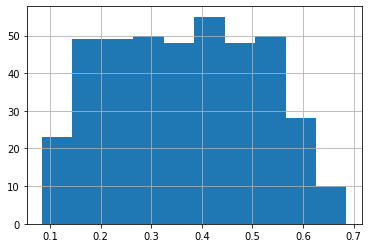

In [139]:
probs['target'].hist()

In [143]:
# submission
# Used 0.55 as threshold because we selected a higher penalty on positive weight false prediction, hence tried to 
# Compensate it
submission = pd.DataFrame({
        "label": np.where(probs['target']<0.55, 0,1),
        "id": sample_Submission["id"],
        
    })
submission.to_csv('lg_pos_weight.csv', index=False)

In [ ]:
# # Oversampling used but not given trustworthy results
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X_traino,  y_traino = smote.fit_resample(X_train, y_train)

**XGBM also not gave good results, LGBM best out of all still not good to avoid this correlation problem**

In [1]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()

# import gc
# import xgboost as xgb
# oof = np.zeros(len(x_train))
# preds = np.zeros(len(x_test))

# skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 44)

# for i, (idxT, idxV) in enumerate( skf.split(x_train, Y_train)):
                                 
#     print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        
#     xgb_params = {
#               'booster' : 'gbtree',
#               'max_depth' : 25,
#               'gamma' : 12,
#               'eta' : 0.08,
#               'objective' : 'binary:logistic',
#                "scale_pos_weight":1,
#               'eval_metric': 'auc',
#               'subsample' : 0.8,
#               'colsample_bytree' : 0.85,
#               'min_child_weight' : 3,
#               'max_delta_step' : 2,
#               "random_state":42
#               }

                                 
#     ################ Fitting ################               
#   #  X_traino,  y_traino = smote.fit_resample(x_train.iloc[idxT], Y_train.iloc[idxT])
#     train = xgb.DMatrix(data = x_train.iloc[idxT],label=Y_train.iloc[idxT], enable_categorical = True)
#     valid = xgb.DMatrix(data=x_train.iloc[idxV],label=Y_train.iloc[idxV], enable_categorical = True)
#     clf = xgb.train(xgb_params, dtrain=train,
#         num_boost_round=5000,evals=[(valid,'valid')],
#         early_stopping_rounds=200,maximize=True,
#         verbose_eval=100)   
    
#     oof[idxV] += clf.predict(valid)                             
#     ####################### Test data pred ##################                             
#     test = xgb.DMatrix(data=x_test, enable_categorical = True)
#     preds += clf.predict(test)/skf.n_splits
#     del clf; x=gc.collect()
                              
# print('#'*20)
# false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train.values,oof)
# # may differ
# print (auc(false_positive_rate, true_positive_rate))                                

### What actually is Coorelation problem or say Train/Test Similarity problem

We used the methid described in [this](https://www.kaggle.com/shikhar1/train-test-similarity) kernel and able to find actiually that the train and test data have good amount of dissimilarity in  their distributions which made the cross validation of train to fail on test data + the submission swap we saw on private leaderboard is not due to overfitting but lack of data similarity.